#### IMPORT LIBRARIES

In [1]:
import numpy as np
import h5py as h5

import torch
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
from importlib import reload, import_module

import glob
import os

import pdb
from PIL import Image as im
import _pickle as pickle


from functions import MyDataset, customTransform, get_variable, get_numpy, compute_gradient, psnr_1

#### DATASET PATH

In [2]:
if os.name == 'nt':
    dataset_file = r"C:\Users\mummu\Documents\Datasets\srinivasan\trainset\h5\8bit.h5"
    test_file    = r"C:\Users\mummu\Documents\Datasets\srinivasan\testset\h5\8bit.h5"
    model_file   = r"model\model.pt"
    network_file = r"network"
    trainwr_file = r"runs\train"
    testwr_file  = r"runs\test"
elif os.name == 'posix':
    raise NotImplementedError

#### BASIC PARAMETERS

In [3]:
patch_size     = 192
batch_size     = 300
minibatch_size = 10
gamma_val      = 0.4
lfsize         = [372, 540, 7, 7]
num_workers    = 0
num_test       = 10
num_minibatch  = batch_size//minibatch_size
batch_affine   = True
num_epochs     = 10000

#### INITIALIZE FUNCTIONS

In [4]:
data_transform = transforms.Compose([transforms.ToTensor(), 
                                     transforms.Lambda(customTransform)])

train_dataset  = MyDataset(dataset_file, lfsize, data_transform)
test_dataset   = MyDataset(test_file, lfsize, data_transform)

train_loader   = torch.utils.data.DataLoader(train_dataset, batch_size=minibatch_size, num_workers=num_workers, shuffle=True)
test_loader    = torch.utils.data.DataLoader(train_dataset, batch_size=minibatch_size, num_workers=num_workers, shuffle=True)

#### LOOKING FOR SAVED MODEL

In [5]:
network_module = import_module(network_file)
reload(network_module)
Net = network_module.Net

net = Net((patch_size, patch_size), minibatch_size, lfsize, batchAffine=batch_affine)
if torch.cuda.is_available():
    print('##converting network to cuda-enabled')
    net.cuda()

try:
    checkpoint = torch.load(model_file)
    
    epoch_id = checkpoint['epoch']
    net.load_state_dict(checkpoint['model'].state_dict())
    print('Model successfully loaded.')
    
except:
    print('No model.')
    epoch_id = 0

##converting network to cuda-enabled
Model successfully loaded.


#### TRAINING SETTINGS

In [6]:
criterion1 = nn.L1Loss()
criterion2 = nn.L1Loss()
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))

In [7]:
def train_epoch():
    costs = []
    psnr_vec = []
            
    for batch_num in range(num_minibatch):
        
        # fetching training batch
        corners, pers, ind = next(iter(train_loader))
        
        # converting to trainable variables
        X_corners = get_variable(corners)
        T_view = get_variable(pers)
        p = get_variable(ind[:,0])
        q = get_variable(ind[:,-1])
                
        optimizer.zero_grad()
        
        # Forward pass
        O_view, _ = net(X_corners, p, q)
        
        # Computing batch loss
        batch_loss = criterion1(O_view, T_view) + .5*criterion2(compute_gradient(O_view),
                                                          compute_gradient(T_view))
        
        # Backpropagation
        batch_loss.backward()
        optimizer.step()

        # recording performance
        costs.append(get_numpy(batch_loss))
        net_out = get_numpy(O_view)
        Y = get_numpy(T_view)      
        psnr_vec.append([psnr_1(np.squeeze(net_out[i]), np.squeeze(Y[i])) for i in range(minibatch_size)])
    
        
    return np.mean(costs), np.mean(psnr_vec)

def eval_epoch():
    costs = []
    psnr_vec = []
    
    for batch_num in range(num_test):
        
        # fetching training batch
        corners, pers, ind = next(iter(test_loader))
        
        # converting to trainable variables
        X_corners = get_variable(corners)
        T_view = get_variable(pers)
        p = get_variable(ind[:,0])
        q = get_variable(ind[:,-1])

        with torch.no_grad():
            # Forward pass
            O_view, _ = net(X_corners, p, q)
            
            # Computing batch loss
            batch_loss = criterion1(O_view, T_view) + .5*criterion2(compute_gradient(O_view), compute_gradient(T_view))
            
            # recording performance
            costs.append(get_numpy(batch_loss))
            net_out = get_numpy(O_view)
            Y = get_numpy(T_view)
            psnr_vec.append([psnr_1(np.squeeze(net_out[i]), np.squeeze(Y[i])) for i in range(minibatch_size)])

    return np.mean(costs), np.mean(psnr_vec)

> <ipython-input-7-9a1001ff7f96>(21)train_epoch()
-> with torch.no_grad():
(Pdb) (get_numpy(p[p==q]) == -1).any()
False
(Pdb) c


C:\Users\mummu\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\functional.py:2404: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


> <ipython-input-7-9a1001ff7f96>(16)train_epoch()
-> pdb.set_trace()
(Pdb) (get_numpy(p[p==q]) == -1).any()
True
(Pdb) print(p)
tensor([ 0.3333, -1.0000, -0.6667, -1.0000,  1.0000,  1.0000, -0.3333,  0.3333,
         0.3333,  0.3333], device='cuda:0', dtype=torch.float64)
(Pdb) print(q)
tensor([ 0.6667, -1.0000, -0.3333, -0.3333, -0.6667, -0.6667, -0.6667,  0.0000,
         0.3333, -0.3333], device='cuda:0', dtype=torch.float64)
(Pdb) n
> <ipython-input-7-9a1001ff7f96>(21)train_epoch()
-> with torch.no_grad():
(Pdb) 
> <ipython-input-7-9a1001ff7f96>(22)train_epoch()
-> O_view = net(X_corners, p, q)
(Pdb) 
> <ipython-input-7-9a1001ff7f96>(25)train_epoch()
-> batch_loss = criterion1(O_view, T_view) + .5*criterion2(compute_gradient(O_view),
(Pdb) O_view.shape
torch.Size([10, 3, 192, 192])
(Pdb) n
> <ipython-input-7-9a1001ff7f96>(26)train_epoch()
-> compute_gradient(T_view))
(Pdb) 
> <ipython-input-7-9a1001ff7f96>(33)train_epoch()
-> costs.append(get_numpy(batch_loss))
(Pdb) 
> <ipython-in

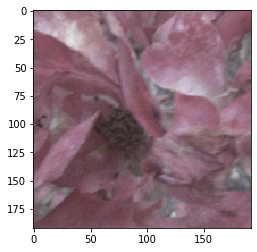

(Pdb) plt.imshow((Y[1].transpose(1,2,0)+1)/2, vmin = 0.0, vmax = 1.0); plt.pause(1);


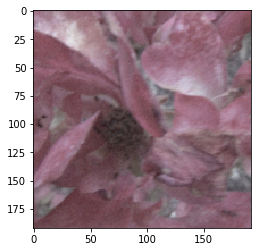

(Pdb) c
> <ipython-input-7-9a1001ff7f96>(16)train_epoch()
-> pdb.set_trace()
(Pdb) (get_numpy(p[p==q]) == -1).any()
True
(Pdb) print(p)
tensor([ 0.3333,  1.0000, -0.6667, -0.3333,  1.0000,  0.3333,  0.3333, -1.0000,
        -0.6667,  0.0000], device='cuda:0', dtype=torch.float64)
(Pdb) print(q)
tensor([-1.0000,  0.0000, -1.0000,  1.0000,  0.0000,  0.0000,  0.0000, -1.0000,
         0.6667, -1.0000], device='cuda:0', dtype=torch.float64)
(Pdb) torch.save((X_corners,T_view),'tensor.pt')
(Pdb) plt.imshow(get_numpy(X_corners[7,:3].permute(1,2,0)+1)/2, vmin = 0.0, vmax = 1.0); plt.pause(1);


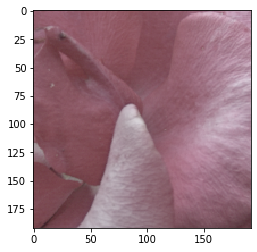

(Pdb) s
> <ipython-input-7-9a1001ff7f96>(21)train_epoch()
-> with torch.no_grad():
(Pdb) s
--Call--
> c:\users\mummu\appdata\local\continuum\anaconda3\lib\site-packages\torch\autograd\grad_mode.py(37)__enter__()
-> def __enter__(self):
(Pdb) 
> c:\users\mummu\appdata\local\continuum\anaconda3\lib\site-packages\torch\autograd\grad_mode.py(38)__enter__()
-> self.prev = torch.is_grad_enabled()
(Pdb) 
> c:\users\mummu\appdata\local\continuum\anaconda3\lib\site-packages\torch\autograd\grad_mode.py(39)__enter__()
-> torch._C.set_grad_enabled(False)
(Pdb) 
--Return--
> c:\users\mummu\appdata\local\continuum\anaconda3\lib\site-packages\torch\autograd\grad_mode.py(39)__enter__()->None
-> torch._C.set_grad_enabled(False)
(Pdb) 
> <ipython-input-7-9a1001ff7f96>(22)train_epoch()
-> O_view = net(X_corners, p, q)
(Pdb) 
--Call--
> c:\users\mummu\appdata\local\continuum\anaconda3\lib\site-packages\torch\nn\modules\module.py(531)__call__()
-> def __call__(self, *input, **kwargs):
(Pdb) s
> c:\users\mu

-> if '_buffers' in self.__dict__:
(Pdb) 
> c:\users\mummu\appdata\local\continuum\anaconda3\lib\site-packages\torch\nn\modules\module.py(577)__getattr__()
-> _buffers = self.__dict__['_buffers']
(Pdb) 
> c:\users\mummu\appdata\local\continuum\anaconda3\lib\site-packages\torch\nn\modules\module.py(578)__getattr__()
-> if name in _buffers:
(Pdb) 
> c:\users\mummu\appdata\local\continuum\anaconda3\lib\site-packages\torch\nn\modules\module.py(580)__getattr__()
-> if '_modules' in self.__dict__:
(Pdb) 
> c:\users\mummu\appdata\local\continuum\anaconda3\lib\site-packages\torch\nn\modules\module.py(581)__getattr__()
-> modules = self.__dict__['_modules']
(Pdb) 
> c:\users\mummu\appdata\local\continuum\anaconda3\lib\site-packages\torch\nn\modules\module.py(582)__getattr__()
-> if name in modules:
(Pdb) 
> c:\users\mummu\appdata\local\continuum\anaconda3\lib\site-packages\torch\nn\modules\module.py(583)__getattr__()
-> return modules[name]
(Pdb) 
--Return--
> c:\users\mummu\appdata\local\conti

           -1.0000e+00, -1.0000e+00]]]], device='cuda:0')
(Pdb) input[7]
tensor([[[ 0.1286,  0.1360,  0.1505,  ...,  0.4941,  0.4183,  0.4078],
         [ 0.1505,  0.1433,  0.1505,  ...,  0.4595,  0.3917,  0.4131],
         [ 0.1647,  0.1505,  0.1360,  ...,  0.4236,  0.4288,  0.4131],
         ...,
         [-0.0860, -0.0963, -0.1067,  ..., -0.1976, -0.2101, -0.2360],
         [-0.0963, -0.0963, -0.1067,  ..., -0.1976, -0.1854, -0.2360],
         [-0.0963, -0.1173, -0.1391,  ..., -0.2101, -0.1976, -0.1854]],

        [[-0.2775, -0.2775, -0.2494,  ...,  0.2127,  0.1286,  0.0984],
         [-0.2633, -0.2633, -0.2494,  ...,  0.1856,  0.1061,  0.1137],
         [-0.2360, -0.2633, -0.2775,  ...,  0.1212,  0.1286,  0.0984],
         ...,
         [-0.4525, -0.4751, -0.4992,  ..., -0.4751, -0.4992, -0.5253],
         [-0.4751, -0.4525, -0.4751,  ..., -0.4992, -0.4751, -0.5253],
         [-0.4525, -0.4751, -0.4751,  ..., -0.4992, -0.4751, -0.4751]],

        [[-0.1854, -0.1618, -0.1391,  ..., 

-> if name in _parameters:
(Pdb) 
> c:\users\mummu\appdata\local\continuum\anaconda3\lib\site-packages\torch\nn\modules\module.py(575)__getattr__()
-> return _parameters[name]
(Pdb) 
--Return--
> c:\users\mummu\appdata\local\continuum\anaconda3\lib\site-packages\torch\nn\modules\module.py(575)__getattr__()->Parameter con...res_grad=True)
-> return _parameters[name]
(Pdb) 
--Call--
> c:\users\mummu\appdata\local\continuum\anaconda3\lib\site-packages\torch\nn\modules\conv.py(334)conv2d_forward()
-> def conv2d_forward(self, input, weight):
(Pdb) s
> c:\users\mummu\appdata\local\continuum\anaconda3\lib\site-packages\torch\nn\modules\conv.py(335)conv2d_forward()
-> if self.padding_mode == 'circular':
(Pdb) 
> c:\users\mummu\appdata\local\continuum\anaconda3\lib\site-packages\torch\nn\modules\conv.py(341)conv2d_forward()
-> return F.conv2d(input, weight, self.bias, self.stride,
(Pdb) self.bias
(Pdb) s
--Call--
> c:\users\mummu\appdata\local\continuum\anaconda3\lib\site-packages\torch\nn\modu

       device='cuda:0')
(Pdb) n
> c:\users\mummu\appdata\local\continuum\anaconda3\lib\site-packages\torch\nn\functional.py(989)elu()
-> if inplace:
(Pdb) 
> c:\users\mummu\appdata\local\continuum\anaconda3\lib\site-packages\torch\nn\functional.py(992)elu()
-> result = torch._C._nn.elu(input, alpha)
(Pdb) 
> c:\users\mummu\appdata\local\continuum\anaconda3\lib\site-packages\torch\nn\functional.py(993)elu()
-> return result
(Pdb) result[7]
tensor([[[ 0.2611,  0.2963,  0.3692,  ...,  0.6971,  0.7456, -0.5115],
         [ 0.2820,  0.2987,  0.2834,  ..., -0.3729, -0.0612, -0.8258],
         [ 0.1256,  0.1264,  0.2170,  ..., -0.3878, -0.1255, -0.8443],
         ...,
         [-0.4888,  0.2675,  0.3040,  ...,  0.6325,  0.5167,  1.7815],
         [-0.4810,  0.2823,  0.2528,  ...,  0.6410,  0.5253,  1.7452],
         [ 0.5906,  1.5869,  1.6385,  ...,  2.0639,  1.9494,  2.2842]],

        [[ 0.7419,  0.1838,  0.1368,  ...,  0.9237,  0.7972,  1.3933],
         [ 0.8052,  0.3248,  0.1643,  ...,  

(tensor([ 0.0835,  0.0700,  1.0256,  1.1913,  1.2364,  0.0327,  2.8603,  1.6733,
         0.2145,  0.0873,  2.0825, -0.0192,  0.5473,  1.2327,  0.4608,  1.4808,
         0.1860,  1.8237,  0.8008,  0.7424,  2.4212,  1.8250,  0.9083,  1.1809,
         0.8504,  1.0300,  0.3318,  0.6619,  1.5056,  0.2013,  1.7551,  2.5605],
       device='cuda:0'), tensor([ 0.4123,  0.3318, 11.4972,  4.8908, 12.3273,  0.3583, 15.6413,  5.7967,
         0.3804,  0.3027,  7.2512,  0.2794,  2.0570,  5.3674,  3.0141,  6.5963,
         0.3154, 11.5688,  3.2672,  3.8241, 10.0558,  9.0464,  7.5037, 11.1010,
         4.2212,  9.6628,  1.3080,  5.0398, 15.1079,  0.3941,  8.7606, 13.9416],
       device='cuda:0'), Parameter containing:
tensor([ 0.8700,  2.0625,  0.1768,  0.0232,  0.0230,  3.2936,  0.2048,  0.0621,
         3.4047,  0.5011,  0.1084,  0.0498,  0.1084,  0.0414,  0.1162,  0.0793,
         1.7612, -0.0885,  0.0277, -0.0793,  0.1481,  0.7407, -0.0495, -0.0695,
        -0.0138,  0.0771,  0.1302, -0.0329, -

BdbQuit: 

In [8]:
valid_accs, train_accs, test_accs = [], [], []

writer_train = SummaryWriter(trainwr_file)
writer_test  = SummaryWriter(testwr_file)

while epoch_id < num_epochs:
    epoch_id += 1
    
    try:   
        net.train()
        train_cost, train_psnr = train_epoch()
        
        net.eval()
        test_cost, test_psnr = eval_epoch()
        
        print("Epoch %d:" % epoch_id)     
        print("Epoch {0:0}, train_cost {1:.2}, psnr {2:.2}".format(epoch_id, train_cost, train_psnr))
        
        writer_train.add_scalar('psnr', train_psnr, epoch_id)
        writer_train.add_scalar('loss', train_cost, epoch_id)
        writer_test.add_scalar('psnr', test_psnr, epoch_id)
        writer_test.add_scalar('loss', test_cost, epoch_id)
        
        torch.save({'model': net, 'epoch': epoch_id}, model_file)
    
    except KeyboardInterrupt:
        print('\nKeyboardInterrupt')
        break